## Denoising diffusion probabilistic model (DDPM)

План на сегодня: реализуем генерацию лиц с обучением Denoising diffusion probalilistic model (DDPM)

### Подготовим данные

Всё с прошлой недели:

In [1]:
from pathlib import Path
from typing import Callable, cast

import lightning as L
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
from lightning.pytorch.loggers import TensorBoardLogger
from PIL import Image
from torch import Tensor, nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [2]:
class ImageDataset(Dataset):
    def __init__(
        self,
        datadir: Path,
        transform: Callable[[Image.Image], Tensor],
        pattern: str = "*.jpg",
    ) -> None:
        self.images = list(datadir.rglob(pattern))
        self.transform = transform

    def __getitem__(self, index) -> Tensor:
        img = Image.open(self.images[index])
        return self.transform(img)

    def __len__(self) -> int:
        return len(self.images)

In [3]:
image_size = 64
transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

In [ ]:
# если работаете локально или в Google Colab, укажите правильный путь до папки с изображениями
datadir = Path("/kaggle/input/celeba-dataset/img_align_celeba")
dataset = ImageDataset(
    datadir,
    transform=transform,
)
print(len(dataset))
print(dataset[0].shape)

202599
torch.Size([3, 64, 64])


In [5]:
loader = DataLoader(dataset, batch_size=16, shuffle=True)

batch = next(iter(loader))
print(batch.shape)

torch.Size([16, 3, 64, 64])


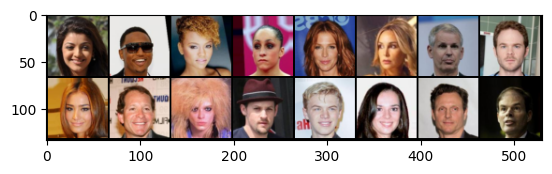

In [6]:
img_grid = torchvision.utils.make_grid(
    tensor=batch,
    nrow=8,
    padding=2,
    normalize=True,
    scale_each=True,
    value_range=(-1, 1)
)

plt.imshow(torchvision.transforms.ToPILImage()(img_grid))

### Denoising diffusion probabilistic model (DDPM)

Блогпост с подробными выкладками: https://lilianweng.github.io/posts/2021-07-11-diffusion-models/

Диффузионные модели в контексте:

<img src="https://lilianweng.github.io/posts/2021-07-11-diffusion-models/generative-overview.png" style="background:white" width="600"/>

**Прямая диффузия** с расписанием дисперсий $\{ \beta_t \in (0, 1) \}_{t = 1}^T$:

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I})$

$q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$

<!-- $q(x_{1:T} | x_0) = \prod_{t = 1}^T q(x_t | x_{t - 1})$ -->

<img src="https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM.png" style="background:white" width="600"/>

Трюк с репараметризацией позволяет получить в явном виде выражение для $\mathbf{x}_t$ от $\mathbf{x}_0$:

$\begin{aligned}
\alpha_t
&= 1 - \beta_t \\
\bar{\alpha}_t &= \prod_{i=1}^t \alpha_i
\end{aligned}$

$\mathbf{x}_t = \sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}$


$q(\mathbf{x}_t \vert \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})$


**Обратная диффузия**

Нам нужно обучить модель $p_{\theta}$ аппроксимировать обратный процесс:



<!-- $p_{\theta}(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \tilde{\mu}(x_t, x_0), \tilde{\beta}(x_t, t))$ - похоже на декодер VAE? -->

$q(\mathbf{x}_{t-1} \vert \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_{t-1}; \color{cyan}{\tilde{\boldsymbol{\mu}}}(\mathbf{x}_t, \mathbf{x}_0), \color{violet}{\tilde{\beta}_t} \mathbf{I})$


$\color{violet}{\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t}$

<!-- $\tilde{\boldsymbol{\mu}}_t (\mathbf{x}_t, \mathbf{x}_0) = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} \mathbf{x}_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} \mathbf{x}_0$ -->

$\color{cyan}{\tilde{\boldsymbol{\mu}}_t = \frac{1}{\sqrt{\alpha_t}} \Big( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_t \Big)}$

Подобно VAE, мы оптимизируем вариационную нижнюю границу:

$
\begin{aligned}
L_\text{VLB} 
&= \mathbb{E}_q [\underbrace{D_\text{KL}(q(\mathbf{x}_T \vert \mathbf{x}_0) \parallel p_\theta(\mathbf{x}_T))}_{L_T} + \sum_{t=2}^T \underbrace{D_\text{KL}(q(\mathbf{x}_{t-1} \vert \mathbf{x}_t, \mathbf{x}_0) \parallel p_\theta(\mathbf{x}_{t-1} \vert\mathbf{x}_t))}_{L_{t-1}} \underbrace{- \log p_\theta(\mathbf{x}_0 \vert \mathbf{x}_1)}_{L_0} ]
\end{aligned}
$

$L_T$ — константа

Для $L_0$ помогает использование отдельного декодера

Для $L_t$ мы и будем учить модель:

$p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}_\theta(\mathbf{x}_t, t), \boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t))$

Раз $\mathbf{x}_t$ доступен в процессе обучения, наша модель будет оценивать $\boldsymbol{\mu}_\theta(\mathbf{x}_t, t)$ через оценку шума $\epsilon_t$:

$\boldsymbol{\mu}_\theta(\mathbf{x}_t, t) = \color{cyan}{\frac{1}{\sqrt{\alpha_t}} \Big( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t) \Big)}$

В итоге в упрощённом виде

$
\begin{aligned}
L_t^\text{simple}
&= \mathbb{E}_{t \sim [1, T], \mathbf{x}_0, \boldsymbol{\epsilon}_t} \Big[\|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t)\|^2 \Big] \\
&= \mathbb{E}_{t \sim [1, T], \mathbf{x}_0, \boldsymbol{\epsilon}_t} \Big[\|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(\sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}_t, t)\|^2 \Big]
\end{aligned}
$

<img src="https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM-algo.png" style="background:white" width="800"/>

#### 1. Класс `Diffuser`

Работу с диффузией (прямой и обратный шаги) вынесем в отдельный модуль:

In [7]:
from __future__ import annotations

import torch
from torch import Tensor, nn


class Diffuser(nn.Module):
    alpha: Tensor
    alpha_bar: Tensor
    beta: Tensor
    sigma: Tensor
    T: int

    def __init__(self, beta: Tensor) -> None:
        super().__init__()
        self.T = len(beta)

        alpha = 1.0 - beta
        alpha_bar = torch.cumprod(alpha, dim=0)
        sigma = torch.sqrt(beta)
        sigma[1:] *= torch.sqrt((1 - alpha_bar[:-1]) / (1 - alpha_bar[1:]))

        self.register_buffer("alpha", alpha)
        self.register_buffer("alpha_bar", alpha_bar)
        self.register_buffer("beta", beta)
        self.register_buffer("sigma", sigma)

    @staticmethod
    def from_linear_schedule(
        beta_0: float = 0.0001, beta_T: float = 0.02, T: int = 1000
    ) -> Diffuser:
        beta = torch.linspace(beta_0, beta_T, T)
        return Diffuser(beta)

    def forward(self, x_0: Tensor, t: Tensor, eps: Tensor) -> Tensor:
        # получение x_t из x_0 с учётом расписания дисперсий
        t = t.view(-1, 1, 1, 1)  # for broadcasting
        x_t = (
            torch.sqrt(self.alpha_bar[t]) * x_0
            + torch.sqrt(1 - self.alpha_bar[t]) * eps
        )
        return x_t

    def reverse(self, x_t: Tensor, t: int, eps_theta: Tensor) -> Tensor:
        # получение x_{t-1} из x_t и оценки \epsilon
        beta_t_coef = (1 - self.alpha[t]) / (torch.sqrt(1 - self.alpha_bar[t]))
        mu_theta = 1 / torch.sqrt(self.alpha[t]) * (x_t - beta_t_coef * eps_theta)
        z = torch.randn_like(x_t) if t > 0 else 0.0
        return mu_theta + self.sigma[t] * z

Посмотрим на работу прямой диффузии:

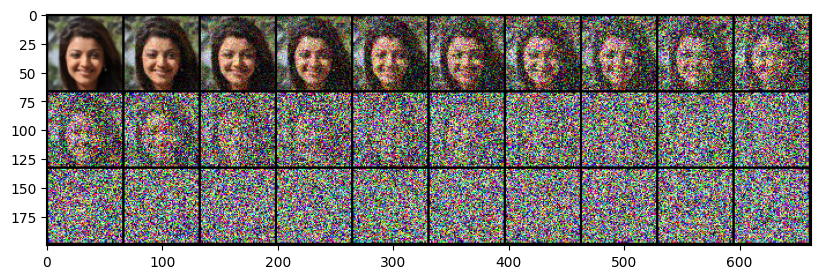

In [8]:
T = 1000
N = 30
nrow = 10
diffuser = Diffuser.from_linear_schedule(beta_0=0.0001, beta_T=0.02, T=T)

ts = torch.linspace(0, T - 1, N).long()
eps = torch.randn(N, 3, image_size, image_size)
# зашумим изображение
noised = diffuser.forward(batch[0].unsqueeze(0), ts, eps)

img_grid = torchvision.utils.make_grid(
    tensor=noised,
    nrow=10,
    padding=2,
    normalize=True,
    scale_each=True,
    value_range=(-1, 1)
)

fig, ax = plt.subplots(figsize=(nrow, N // nrow))
ax.imshow(torchvision.transforms.ToPILImage()(img_grid))

#### 2. Алгоритм обучения и семплирования

А теперь создадим класс для обучения и семплирования, для чего перенесём уравнения из Algorithm 1 в `training_step`, из Algorithm 2 - в `sample`:

In [9]:
import lightning as L
import torch
from lightning.pytorch.utilities.types import OptimizerLRScheduler
from torch import Tensor, nn
from torch.nn import functional as F


class DDPM(L.LightningModule):
    def __init__(
        self, model: nn.Module, diffuser: Diffuser, learning_rate: float = 0.0002
    ):
        super().__init__()
        self.model = model
        self.diffuser = diffuser
        self.T = diffuser.T
        self.learning_rate = learning_rate

    def training_step(self, batch: Tensor, batch_idx: int) -> Tensor:
        # семплируем x ~ q(x), t ~ U[1, T], eps ~ N(0, 1)
        x_0 = batch
        t = torch.randint(0, self.T, size=(batch.shape[0], 1), device=batch.device)
        eps = torch.randn_like(x_0)

        # получение зашумлённого x_t и предсказание добавленного шума
        x_t = self.diffuser.forward(x_0, t, eps)
        eps_theta = self.model.forward(x_t, t)

        loss = F.mse_loss(eps_theta, eps)
        self.log("loss", loss, prog_bar=True)
        return loss

    @torch.no_grad()
    def sample(self, n: int, size: int = 32) -> Tensor:
        self.eval()
        device = next(self.parameters()).device
        x_t = torch.randn(n, 3, size, size, device=device)

        for t in reversed(range(self.T)):
            ts = torch.full((n, 1), fill_value=t, device=device)
            eps_theta = self.model.forward(x_t, ts)
            x_t = self.diffuser.reverse(x_t, t, eps_theta)

        return x_t

    def configure_optimizers(self) -> OptimizerLRScheduler:
        optim = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optim


#### 3. Архитектура модели: time-conditioned U-Net

<img src="../attachments/tdunet.jpeg" style="background:white" width="600"/>

Для примера возьмём U-Net из практики по сегментации, но его придётся модифицировать: теперь на вход модели приходит не только изображение, но и номер шага

Кодировать номер шага можно, напрмер, используя синусоидальные эмбеддинги, как в оригинальном трансформере

d - желаемый размер вектора, кодирующего позицию
for 
$
i \in [1, d] \\
\begin{aligned}
PE(t, 2i) = \sin \left( \frac{t}{10000^{2i / d}} \right) \\
PE(t, 2i + 1) = \cos \left( \frac{t}{10000^{2i / d}} \right)
\end{aligned}
$

In [10]:
import math

class PositionalEncoding(nn.Module):
    pe: Tensor

    def __init__(self, encoding_size: int, max_len: int = 1000):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, encoding_size, 2) * (-math.log(10000.0) / encoding_size))
        pe = torch.zeros(max_len, encoding_size)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, t: Tensor) -> Tensor:
        return self.pe[t]

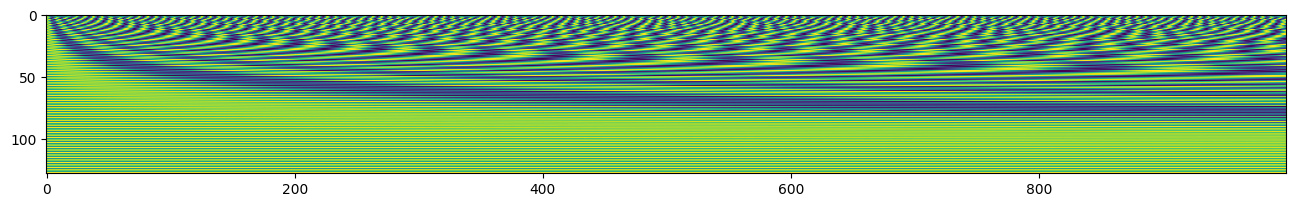

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

plt.imshow(PositionalEncoding(128)(torch.arange(1000)).T)

Также мы сделаем другой строительный блок для модулей Downscaling и Upscaling, основные отличия:
- `GroupNorm` вместо `BatchNorm` (каналы делятся на группы, статистики оцениваются для группы каналов)
- Residual connections
- Обработка эмбеддинга номера шага как дополнительного входа

In [12]:
class ResidualBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        time_embed_size: int,
        drop_rate: float = 0.
    ):
        super().__init__()
        self.norm1 = nn.GroupNorm(num_channels=in_channels, num_groups=32)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.fc = nn.Linear(time_embed_size, out_channels)
        self.norm2 = nn.GroupNorm(num_channels=out_channels, num_groups=32)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)
        self.dropout = nn.Dropout(p=drop_rate, inplace=True)

    def forward(self, x, t_emb: Tensor):
        skip = self.skip(x)
        x = self.conv1(F.silu(self.norm1(x)))
        x += self.fc(F.silu(t_emb.flatten(1)))[:, :, None, None]
        x = self.dropout(F.silu(self.norm2(x)))
        x = self.conv2(x)
        return x + skip

В модулях `Down` и `Up` изменение единственное: они теперь принимают эмбеддинг номера шага

In [13]:
class Down(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_embed_size: int = 32):
        super().__init__()
        self.down = nn.MaxPool2d(2, 2)
        self.conv = ResidualBlock(
            in_channels, out_channels, time_embed_size=time_embed_size
        )

    def forward(self, x: Tensor, t: Tensor):
        x = self.down(x)
        return self.conv(x, t)


class Up(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        bilinear: bool = True,
        time_embed_size: int = 32,
    ):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = ResidualBlock(
                in_channels,
                out_channels,
                time_embed_size=time_embed_size,
            )
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = ResidualBlock(
                in_channels, out_channels, time_embed_size=time_embed_size
            )

    def forward(self, x1: Tensor, x2: Tensor, t: Tensor):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x, t)

Наконец, в UNet мы добавляем модуль `PositionalEncoding` для кодирования текущего номера шага и передачи его во все модули `Up` и `Down`:

In [14]:
class UNet(nn.Module):
    def __init__(
        self,
        n_channels: int,
        n_classes: int,
        channel_sizes: list[int],
        bilinear: bool = False,
        encoding_size: int = 32,
    ):
        super().__init__()
        self.pe = PositionalEncoding(encoding_size)
        # остальное без изменений
        self.in_conv = nn.Conv2d(in_channels=n_channels, out_channels=channel_sizes[0], kernel_size=3, padding=1)
        self.downscaler = self.create_downscaler(channel_sizes, bilinear)
        self.upscaler = self.create_upscaler(channel_sizes[::-1], bilinear)
        self.head = nn.Conv2d(channel_sizes[0], n_classes, kernel_size=1)

    @classmethod
    def create_downscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        factor = 2 if bilinear else 1
        down_factors = [1] * (len(channel_sizes) - 2) + [factor]
        return nn.ModuleList(
            [
                Down(fin, fout // dfactor)
                for fin, fout, dfactor in zip(
                    channel_sizes[:-1], channel_sizes[1:], down_factors
                )
            ]
        )

    @classmethod
    def create_upscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        factor = 2 if bilinear else 1
        up_factors = [factor] * (len(channel_sizes) - 2) + [1]
        return nn.ModuleList(
            [
                Up(fin, fout // ufactor, bilinear=bilinear)
                for fin, fout, ufactor in list(
                    zip(channel_sizes[:-1], channel_sizes[1:], up_factors)
                )
            ]
        )

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        t = self.pe(t) # кодируем шаг один раз
        xs = []
        x = self.in_conv(x)
        for conv in self.downscaler:
            xs.append(x)
            x = conv(x, t)  # передаём шаг сюда

        xs.reverse()
        for conv, act in zip(self.upscaler, xs):
            x = conv(x, act, t)  # и сюда

        out = self.head(x)
        return out


In [15]:
model = UNet(n_channels=3, n_classes=3, channel_sizes=[128, 256, 512, 1024], bilinear=False)
sum([p.numel() for p in model.parameters()])

32110339

In [16]:
x_0 = torch.randn(16, 3, image_size, image_size)
t = torch.randint(0, 1000, size=(16, 1))
eps = model.forward(x_0, t)
print(eps.shape)

torch.Size([16, 3, 64, 64])


#### 4. Запуск обучения

Сделаем callback для отрисовки примеров изображений:

In [17]:
from typing import cast

import lightning as L
import torchvision
from lightning.pytorch.loggers import TensorBoardLogger


class Generate(L.Callback):
    def __init__(self, n: int, image_size: int) -> None:
        super().__init__()
        self.n = n
        self.image_size = image_size

    def on_train_epoch_end(
        self, trainer: L.Trainer, pl_module: L.LightningModule
    ) -> None:
        images = pl_module.sample(self.n, self.image_size)
        grid = torchvision.utils.make_grid(
            tensor=images,
            nrow=8,
            padding=2,
            normalize=True,
            scale_each=True,
            value_range=(-1, 1),
        )
        str_title = f"{pl_module.__class__.__name__}_images"
        logger = cast(TensorBoardLogger, pl_module.logger)
        logger.experiment.add_image(str_title, grid, global_step=pl_module.global_step)


In [18]:
loader = DataLoader(dataset, batch_size=64, shuffle=True)
model = UNet(
    n_channels=3,
    n_classes=3,
    channel_sizes=[64, 128, 256, 512, 1024],
    bilinear=False,
    encoding_size=32,
)
diffuser = Diffuser.from_linear_schedule(beta_0=0.0001, beta_T=0.02, T=1000)
lit = DDPM(model=model, diffuser=diffuser, learning_rate=0.0002)
trainer = L.Trainer(
    max_epochs=1000,
    logger=TensorBoardLogger(save_dir="logs", name="ddpm"),
    limit_train_batches=500,
    callbacks=[Generate(n=16, image_size=image_size)],
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model=lit, train_dataloaders=loader)

Вот что может получиться после обучения на 120k шагов (для хорошего качества по разным оценкам может потребоваться более 500k шагов):

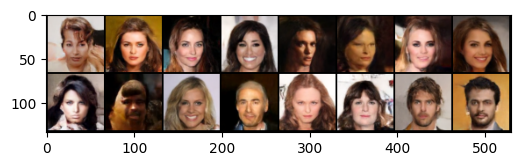

In [ ]:
checkpoint_path = ...
lit.load_state_dict(torch.load(checkpoint_path, weights_only=True)["state_dict"])
images = lit.sample(n=16, size=64)
grid = torchvision.utils.make_grid(
    tensor=images.clip(-1, 1),
    nrow=8,
    padding=2,
    normalize=True,
    scale_each=True,
    value_range=(-1, 1),
)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(torchvision.transforms.ToPILImage()(grid))

Дополнительные материалы:
- [Generative Modeling by Estimating Gradients of the Data Distribution](https://yang-song.net/blog/2021/score/)
- [CS492(D): Diffusion Models and Their Applications](https://mhsung.github.io/kaist-cs492d-fall-2024/) — свежий курс по диффузионным моделям и приложениям
- [Denoising Diffusion Models: A Generative Learning Big Bang](https://cvpr2023-tutorial-diffusion-models.github.io/) (CVPR2023 tutorial)
- [The Annotated Diffusion Model](https://huggingface.co/blog/annotated-diffusion) — ещё одна пошаговая реализация DDPM